In [ ]:
# Check GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Jul 28 07:03:02 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/My\ Drive/

/content/drive/My Drive


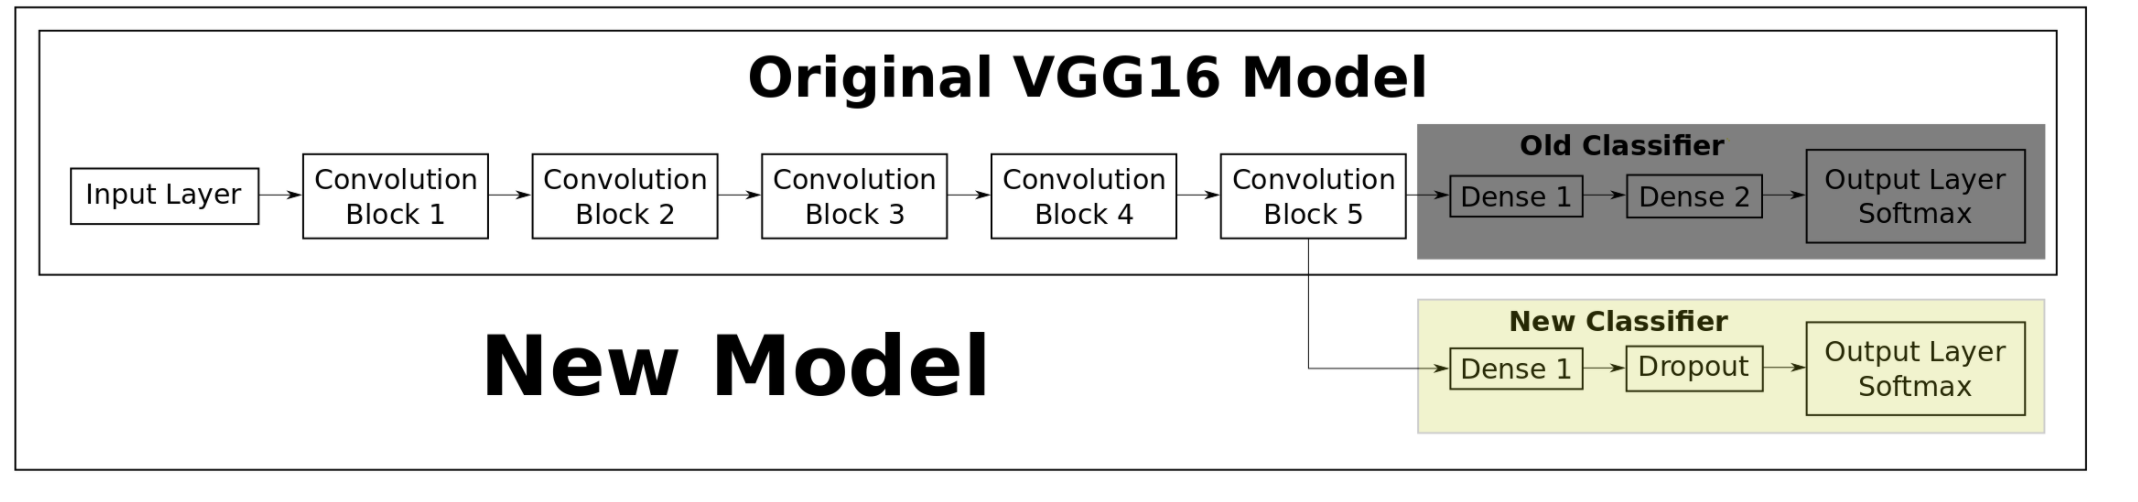

In [ ]:
from IPython.display import Image, display
Image('/content/drive/My Drive/AI/model.png')

In [ ]:
# Imports
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
import numpy as np
import os

%matplotlib inline

In [ ]:
!pip3 install scipy==1.2.1
from scipy import misc, ndimage
from tensorflow.keras import backend as K

In [ ]:
# Imports

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop

tf.__version__

'2.2.0'

#### Data Augmentation 

In [ ]:
# helper function
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows +1
    for i in range(len(ims)):
        sp = f.add_subplot(rows,cols,i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize = 16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [ ]:
gen = ImageDataGenerator(rotation_range=10,width_shift_range=0.1,
        height_shift_range=0.1, shear_range=0.15, zoom_range=0.1,brightness_range=[0.5, 1.5],
        channel_shift_range=10., horizontal_flip=True)

In [ ]:
image_path = '/content/drive/My Drive/AI/AI_Dataset/UTD Visitor Center/augment_pic.jpeg'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  """Entry point for launching an IPython kernel.


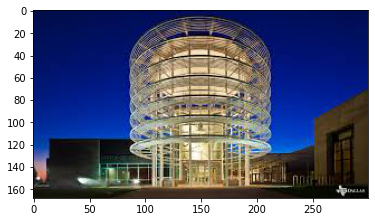

In [ ]:
image = np.expand_dims(ndimage.imread(image_path),0)
plt.imshow(image[0])

In [ ]:
#DONE

#dir = '/content/drive/My Drive/AI/AI_Dataset'
#to_dir = '/content/drive/My Drive/AI/AI_Dataset/UT Blanton Museum of Art/result'
#aug_iter = gen.flow_from_directory(dir, save_to_dir=to_dir, classes=['UT Blanton Museum of Art'])

In [ ]:
#DONE

#aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(10)]

####Splitting data into test and train directories

In [ ]:
##DONE##

split data into train and test directories 
import shutil
import random

root_dir = '/content/drive/My Drive/AI'
classes_dir = ['/UT Blanton Museum of Art',
               '/UT McCombs',
               '/UT Tower',
               '/UT Tower Fountain',
               '/UTD Visitor Center']

test_ratio = 0.20

for cls in classes_dir:
    os.makedirs(root_dir +'/train' + cls, exist_ok=True)
    os.makedirs(root_dir +'/test' + cls, exist_ok=True)

    # Creating partitions of the data after shuffeling
    src = root_dir + '/AI_Dataset' + cls # Folder to copy images from

    allFileNames = os.listdir(src)
    np.random.shuffle(allFileNames)
    train_FileNames, test_FileNames, val_FileNames = np.split(np.array(allFileNames),
                                                              [int(len(allFileNames)* (1 - test_ratio)), 
                                                               int(len(allFileNames))])

    train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
    test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]
  
    print('Total images: ', len(allFileNames))
    print('Training: ', len(train_FileNames))
    print('Testing: ', len(test_FileNames))

    # Copy-pasting images
    for name in train_FileNames:
        shutil.copy(name, root_dir +'/train' + cls)

    for name in test_FileNames:
        shutil.copy(name, root_dir +'/test' + cls)

In [ ]:
# get train and test directories 
train_dir = '/content/drive/My Drive/AI/train'
test_dir = '/content/drive/My Drive/AI/test'

#### Helper functions

In [ ]:
# helper def
def path_join(dirname, filenames):
    return [os.path.join(dirname, filename) for filename in filenames]

In [ ]:
# helper def 
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [ ]:
# helper def
# Import a function from sklearn to calculate the confusion-matrix.
from sklearn.metrics import confusion_matrix
def print_confusion_matrix(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    print("Confusion matrix:")
    
    # Print the confusion matrix as text.
    print(cm)
    
    # Print the class-names for easy reference.
    for i, class_name in enumerate(class_names):
        print("({0}) {1}".format(i, class_name))

In [ ]:
# helper def
def plot_example_errors(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != cls_test)

    # Get the file-paths for images that were incorrectly classified.
    image_paths = np.array(image_paths_test)[incorrect]

    # Load the first 9 images.
    images = load_images(image_paths=image_paths[0:9])
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = cls_test[incorrect]
    
    # Plot the 9 images we have loaded and their corresponding classes.
    # We have only loaded 9 images so there is no need to slice those again.
    plot_images(images=images,
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [ ]:
# helper def
def example_errors():
    # The Keras data-generator for the test-set must be reset
    # before processing. This is because the generator will loop
    # infinitely and keep an internal index into the dataset.
    # So it might start in the middle of the test-set if we do
    # not reset it first. This makes it impossible to match the
    # predicted classes with the input images.
    # If we reset the generator, then it always starts at the
    # beginning so we know exactly which input-images were used.
    generator_test.reset()
    
    # Predict the classes for all images in the test-set.
    y_pred = new_model.predict(generator_test, steps=steps_test)

    # Convert the predicted classes from arrays to integers.
    cls_pred = np.argmax(y_pred,axis=1)

    # Plot examples of mis-classified images.
    plot_example_errors(cls_pred)
    
    # Print the confusion matrix.
    print_confusion_matrix(cls_pred)

In [ ]:
# helper def
def load_images(image_paths):
    # Load the images from disk.
    images = [plt.imread(path) for path in image_paths]

    # Convert to a numpy array and return it.
    return np.asarray(images)

In [ ]:
# helper def
def plot_training_history(history):
    # Get the classification accuracy and loss-value
    # for the training-set.
    acc = history.history['categorical_accuracy']
    loss = history.history['loss']

    # Get it for the validation-set (we only use the test-set).
    val_acc = history.history['val_categorical_accuracy']
    val_loss = history.history['val_loss']

    # Plot the accuracy and loss-values for the training-set.
    plt.plot(acc, linestyle='-', color='b', label='Training Acc.')
    plt.plot(loss, 'o', color='b', label='Training Loss')
    
    # Plot it for the test-set.
    plt.plot(val_acc, linestyle='--', color='r', label='Test Acc.')
    plt.plot(val_loss, 'o', color='r', label='Test Loss')

    # Plot title and legend.
    plt.title('Training and Test Accuracy')
    plt.legend()

    # Ensure the plot shows correctly.
    plt.show()

#### Pre-trained Model: VGG16

In [ ]:
# download full VGG16 model 
model = VGG16(include_top=True, weights='imagenet')

553467904/553467096 [==============================] - 6s 0us/step


####Input Pipeline

In [ ]:
# find shape of the tensors expected as input by the pre-trained VGG16 model
input_shape = model.layers[0].output_shape[0][1:3]
input_shape

(224, 224)

In [ ]:
# further augmentation
datagen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=180,
      shear_range=0.1,
      zoom_range=[0.9, 1.5],
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')

datagen_test = ImageDataGenerator(rescale=1./255)

In [ ]:
batch_size = 32

In [ ]:
if True:
    save_to_dir = None
else:
    save_to_dir='/content/drive/My Drive/temp/'

In [ ]:
# reading data from drive 
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    save_to_dir=save_to_dir)

Found 15159 images belonging to 5 classes.


In [ ]:
# reading data from drive 
generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)

Found 3792 images belonging to 5 classes.


In [ ]:
# testing steps size
steps_test = generator_test.n / batch_size
steps_test

118.5

In [ ]:
# file paths for later
image_paths_train = path_join(train_dir, generator_train.filenames)
image_paths_test = path_join(test_dir, generator_test.filenames)

In [ ]:
# class numbers for images
cls_train = generator_train.classes
cls_test = generator_test.classes

In [ ]:
# class names
class_names = list(generator_train.class_indices.keys())
class_names

['UT Blanton Museum of Art',
 'UT McCombs',
 'UT Tower',
 'UT Tower Fountain',
 'UTD Visitor Center']

In [ ]:
# class numbers for dataset
num_classes = generator_train.num_classes
num_classes

5

####Testing model before training

 Plotting a few images from dataset

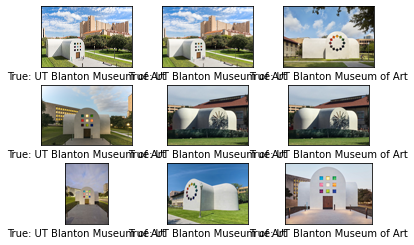

In [ ]:
# Load the first images from the train-set.
images = load_images(image_paths=image_paths_train[0:9])

# Get the true classes for those images.
cls_true = cls_train[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=True)

Adjusting class weights due to my imbalanced dataset

In [ ]:
# balancing dataset
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(cls_train),
                                    y=cls_train)
class_weight_dict = dict(enumerate(class_weights))

In [ ]:
class_weight_dict

{0: 3.661594202898551,
 1: 0.5696730552423901,
 2: 0.6479589655909382,
 3: 0.7791827293754818,
 4: 6.906150341685649}

In [ ]:
class_names

['UT Blanton Museum of Art',
 'UT McCombs',
 'UT Tower',
 'UT Tower Fountain',
 'UTD Visitor Center']

Predicting sample images before transfer learning

In [ ]:
def predict(image_path):
    # Load and resize the image using PIL.
    img = PIL.Image.open(image_path)
    img_resized = img.resize(input_shape, PIL.Image.LANCZOS)

    # Plot the image.
    plt.imshow(img_resized)
    plt.show()

    # Convert the PIL image to a numpy-array with the proper shape.
    img_array = np.expand_dims(np.array(img_resized), axis=0)

    # Use the VGG16 model to make a prediction.
    # This outputs an array with 1000 numbers corresponding to
    # the classes of the ImageNet-dataset.
    pred = model.predict(img_array)
    
    # Decode the output of the VGG16 model.
    pred_decoded = decode_predictions(pred)[0]

    # Print the predictions.
    for code, name, score in pred_decoded:
        print("{0:>6.2%} : {1}".format(score, name))

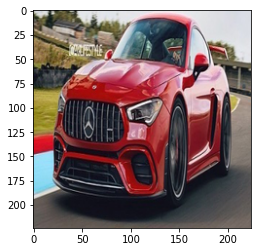

40960/35363 [==================================] - 0s 0us/step
43.87% : racer
24.27% : pickup
11.71% : sports_car
 3.93% : cab
 3.07% : car_wheel


In [ ]:
predict(image_path='/content/drive/My Drive/merc.jpg')

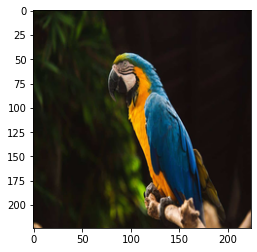

63.15% : macaw
35.78% : bee_eater
 0.83% : toucan
 0.08% : sulphur-crested_cockatoo
 0.05% : vine_snake


In [ ]:
predict(image_path='/content/drive/My Drive/par.jpeg')

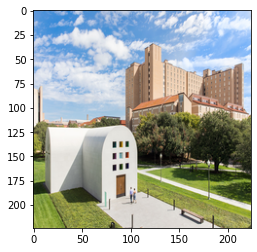

16.56% : dam
15.74% : pier
15.25% : patio
 4.08% : bakery
 2.48% : mosque


In [ ]:
predict(image_path=image_paths_train[0])

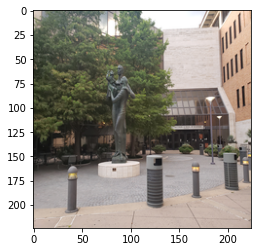

14.66% : street_sign
 7.26% : parking_meter
 5.47% : sundial
 5.30% : obelisk
 4.83% : patio


In [ ]:
predict(image_path=image_paths_train[5000])

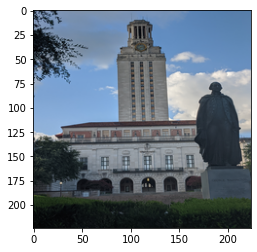

41.07% : obelisk
18.74% : pedestal
 7.41% : palace
 5.51% : stupa
 4.79% : dome


In [ ]:
predict(image_path=image_paths_test[2280])

####Transfer Learning 

In [ ]:
# viewing the current layers of VGG16
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# get last layer
transfer_layer = model.get_layer('block5_pool')
transfer_layer.output

<tf.Tensor 'block5_pool/Identity:0' shape=(None, 7, 7, 512) dtype=float32>

In [ ]:
# New model that has everything from input to conv block 5
conv_model = Model(inputs=model.input,
                   outputs=transfer_layer.output)

In [ ]:
# adding more layers
new_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
new_model.add(conv_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
new_model.add(Flatten())

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(1024, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.5))

# Add the final layer for the actual classification.
new_model.add(Dense(num_classes, activation='softmax'))

In [ ]:
optimizer = Adam(lr=1e-5)

In [ ]:
loss = 'categorical_crossentropy'

In [ ]:
metrics = ['categorical_accuracy']


In [ ]:
def print_layer_trainable():
    for layer in conv_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

In [ ]:
print_layer_trainable()

True:	input_1
True:	block1_conv1
True:	block1_conv2
True:	block1_pool
True:	block2_conv1
True:	block2_conv2
True:	block2_pool
True:	block3_conv1
True:	block3_conv2
True:	block3_conv3
True:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


In [ ]:
# disable base
conv_model.trainable = False
for layer in conv_model.layers:
    layer.trainable = False
print_layer_trainable()

False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_pool
False:	block5_conv1
False:	block5_conv2
False:	block5_conv3
False:	block5_pool


In [ ]:
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
epochs = 5
steps_per_epoch = 237

In [ ]:
checkpoint_path = "/content/drive/My Drive/AI/checkpoints_tutorial_two/"
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
history = new_model.fit(x=generator_train,
                        epochs=epochs,
                        steps_per_epoch=steps_per_epoch,
                        class_weight=class_weight_dict,
                        validation_data=generator_test,
                        validation_steps=steps_test,
                        callbacks=[cp_callback])

Epoch 1/5
237/237 [==============================] - ETA: 0s - loss: 1.0512 - categorical_accuracy: 0.6026 
Epoch 00001: saving model to /content/drive/My Drive/AI/checkpoints_tutorial_two/
237/237 [==============================] - 12723s 54s/step - loss: 1.0512 - categorical_accuracy: 0.6026 - val_loss: 0.6091 - val_categorical_accuracy: 0.8499
Epoch 2/5
237/237 [==============================] - ETA: 0s - loss: 0.4586 - categorical_accuracy: 0.8514 
Epoch 00002: saving model to /content/drive/My Drive/AI/checkpoints_tutorial_two/
237/237 [==============================] - 10033s 42s/step - loss: 0.4586 - categorical_accuracy: 0.8514 - val_loss: 0.4176 - val_categorical_accuracy: 0.8803
Epoch 3/5
237/237 [==============================] - ETA: 0s - loss: 0.3293 - categorical_accuracy: 0.8911 
Epoch 00003: saving model to /content/drive/My Drive/AI/checkpoints_tutorial_two/
237/237 [==============================] - 10034s 42s/step - loss: 0.3293 - categorical_accuracy: 0.8911 - val_l

In [ ]:
# getting previous weights
new_model.load_weights(checkpoint_path)

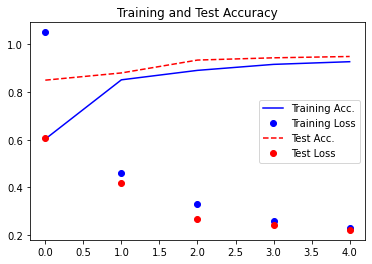

In [ ]:
# plotting results
plot_training_history(history)

In [ ]:
# evaluate on test data
result = new_model.evaluate(generator_test, steps=steps_test)

119/118 [==============================] - 1837s 15s/step - loss: 0.2209 - categorical_accuracy: 0.9494


In [ ]:
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

Test-set classification accuracy: 94.94%


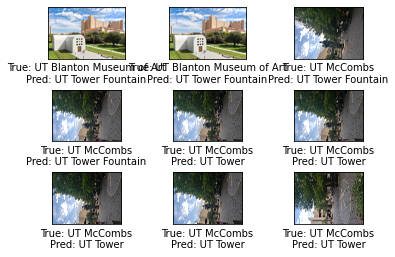

Confusion matrix:
[[ 206    0    0    2    0]
 [  25 1293    8    5    0]
 [  43    3 1108    9    3]
 [  11   39   36  889    2]
 [   3    3    0    0  104]]
(0) UT Blanton Museum of Art
(1) UT McCombs
(2) UT Tower
(3) UT Tower Fountain
(4) UTD Visitor Center


In [ ]:
# plot wrongly classified images
example_errors()

####Fine tuning

In [ ]:
conv_model.trainable = True

In [ ]:
for layer in conv_model.layers:
    # Boolean whether this layer is trainable.
    trainable = ('block5' in layer.name or 'block4' in layer.name)
    
    # Set the layer's bool.
    layer.trainable = trainable

In [ ]:
print_layer_trainable()

False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


In [ ]:
optimizer_fine = Adam(lr=1e-7)

In [ ]:
new_model.compile(optimizer=optimizer_fine, loss=loss, metrics=metrics)

In [ ]:
history = new_model.fit(x=generator_train,
                        epochs=epochs,
                        steps_per_epoch=steps_per_epoch,
                        class_weight=class_weight_dict,
                        validation_data=generator_test,
                        validation_steps=steps_test,
                        callbacks=[cp_callback])

Epoch 1/5
237/237 [==============================] - ETA: 0s - loss: 0.1772 - categorical_accuracy: 0.9401 
Epoch 00001: saving model to /content/drive/My Drive/AI/checkpoints_tutorial_two/
237/237 [==============================] - 13163s 56s/step - loss: 0.1772 - categorical_accuracy: 0.9401 - val_loss: 0.1531 - val_categorical_accuracy: 0.9644
Epoch 2/5
237/237 [==============================] - ETA: 0s - loss: 0.1555 - categorical_accuracy: 0.9488 
Epoch 00002: saving model to /content/drive/My Drive/AI/checkpoints_tutorial_two/
237/237 [==============================] - 10853s 46s/step - loss: 0.1555 - categorical_accuracy: 0.9488 - val_loss: 0.1415 - val_categorical_accuracy: 0.9673
Epoch 3/5
237/237 [==============================] - ETA: 0s - loss: 0.1574 - categorical_accuracy: 0.9457 
Epoch 00003: saving model to /content/drive/My Drive/AI/checkpoints_tutorial_two/
237/237 [==============================] - 10430s 44s/step - loss: 0.1574 - categorical_accuracy: 0.9457 - val_l

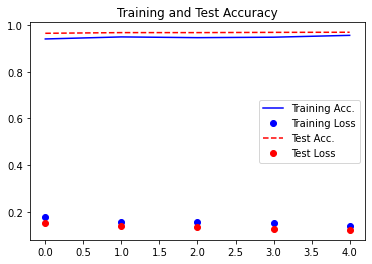

In [ ]:
plot_training_history(history)


In [ ]:
result = new_model.evaluate(generator_test, steps=steps_test)

119/118 [==============================] - 1021s 9s/step - loss: 0.1227 - categorical_accuracy: 0.9689


In [ ]:
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

Test-set classification accuracy: 96.89%


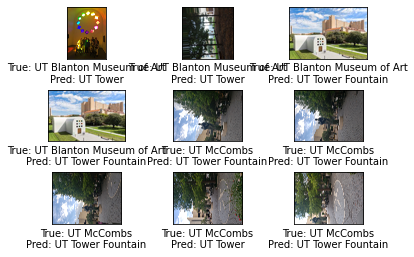

Confusion matrix:
[[ 204    0    2    2    0]
 [  11 1310    2    8    0]
 [  15    1 1139   10    1]
 [   0   25   34  916    2]
 [   2    3    0    0  105]]
(0) UT Blanton Museum of Art
(1) UT McCombs
(2) UT Tower
(3) UT Tower Fountain
(4) UTD Visitor Center


In [ ]:
example_errors()

In [ ]:
new_model.load_weights(checkpoint_path)

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT] #Dynamic range quantization 4x smaller
tflite_quant_model = converter.convert()
# Save the TF Lite model.
with tf.io.gfile.GFile('tutorial_two_model.tflite', 'wb') as f: 
  f.write(tflite_quant_model)